# Harris Corner Detection

This notebook looks into demonstrating every single step of the Harris Corner Detection implementation.

Let's first setup our environment.

In [1]:
import cv2 as cv
import numpy as np
from skimage import io
from scipy import ndimage
from google.colab.patches import cv_imshow

The image used for this demonstration is obtained from Google Images Search which is then stored to my personal GitHub [here](https://github.com/dzniel/binus-computer-vision-course/blob/main/image/traveloka.jpg).

In [2]:
img = io.imread("https://github.com/dzniel/binus-computer-vision-course/blob/main/image/traveloka.jpg?raw=true")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY).astype(np.float64)
img.shape, gray_img.shape

((658, 1170, 3), (658, 1170))

Let's take a look at the image used.

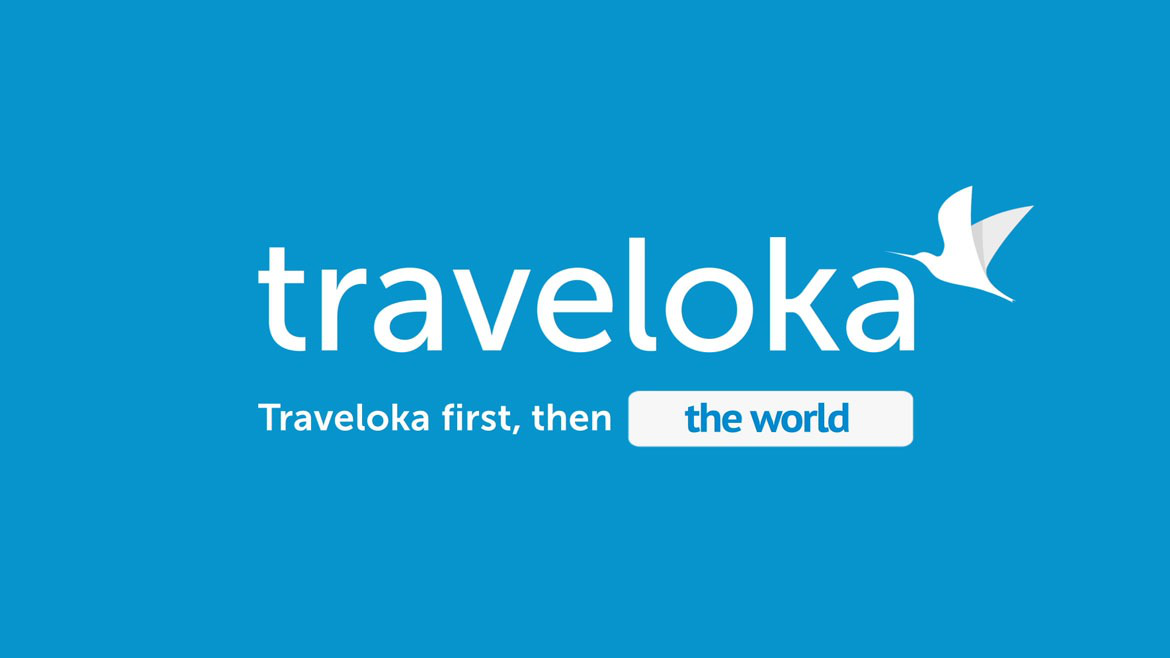

In [3]:
cv_imshow(img)

The image is directly converted to grayscale beforehand for demonstration purposes.

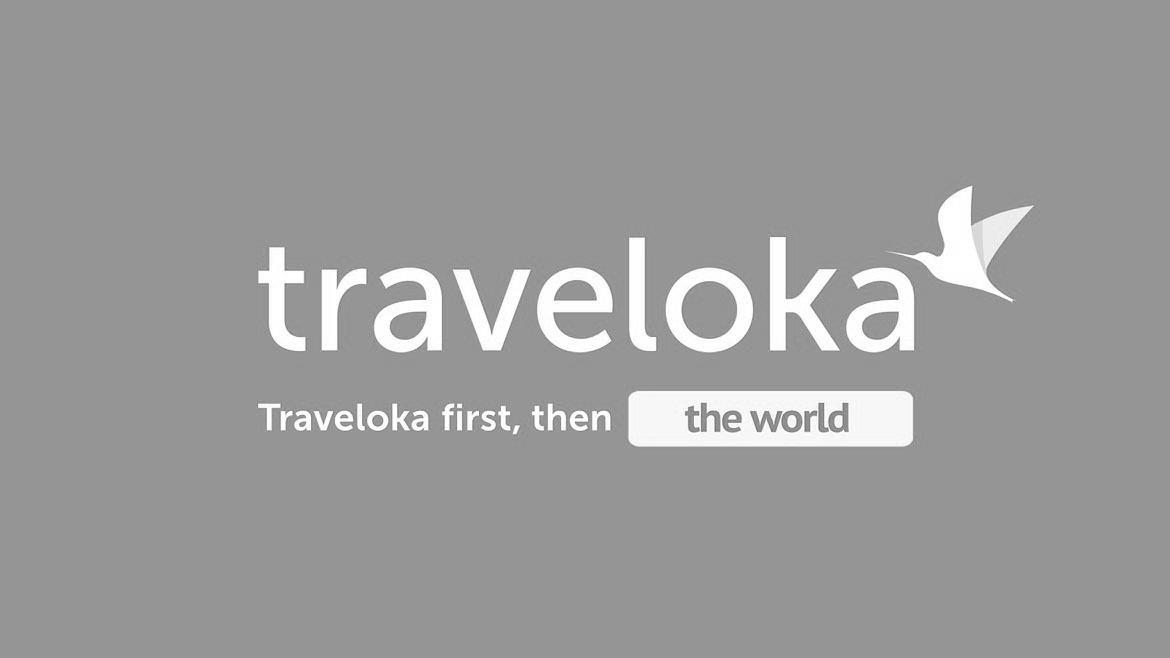

In [4]:
cv_imshow(gray_img)

Let's apply a gaussian blur to reduce the image noises.

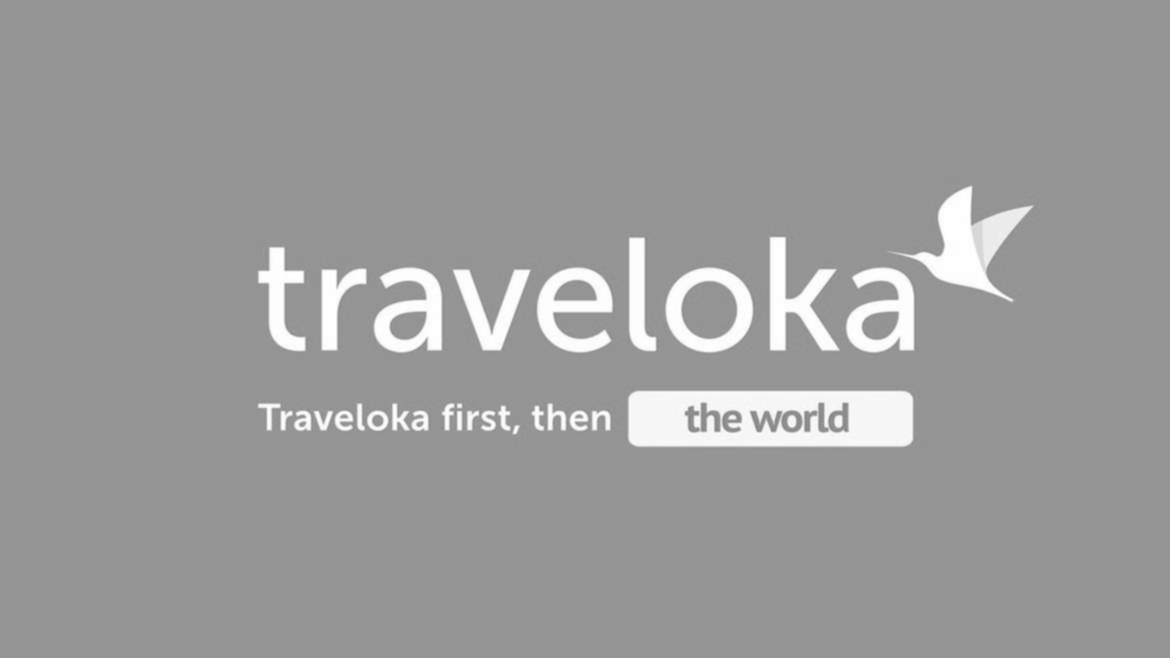

In [5]:
gaussian_img = cv.GaussianBlur(gray_img, (3, 3), 0)
cv_imshow(gaussian_img)

What is the height and width of our image?

In [6]:
height, width = gaussian_img.shape
height, width

(658, 1170)

To proceed, we need to compute the gaussian derivatives at each pixel utilizing the Sobel operator kernel.

In [7]:
R_matrix = np.zeros((height, width))
dx = ndimage.filters.convolve(gaussian_img, np.array([[-1, 0, 1],
                                                      [-2, 0, 2],
                                                      [-1, 0, 1]],
                                                     dtype=np.float32))

dy = ndimage.filters.convolve(gaussian_img, np.array([[1, 2, 1],
                                                      [0, 0, 0],
                                                      [-1, -2, -1]],
                                                     dtype=np.float32))

ddx = np.square(dx)
ddy = np.square(dy)
dxy = dx * dy

Then, we compute the second moment matrix M in a gaussian window around each pixel and the corner response function (R).

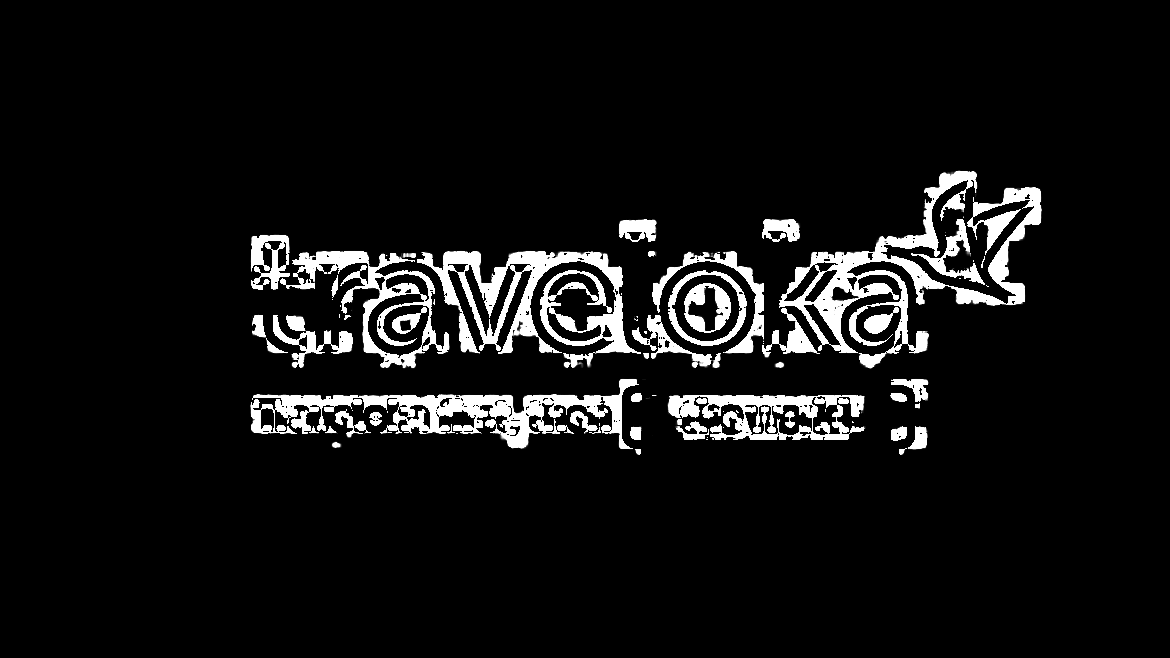

In [8]:
window_size = 5
alpha = 0.05
offset = int(window_size / 2)
for y in range(offset, height - offset):
  for x in range(offset, width - offset):
    sum_x = np.sum(ddx[y - offset: y + offset + 1, x - offset: x + offset + 1])
    sum_y = np.sum(ddy[y - offset: y + offset + 1, x - offset: x + offset + 1])
    sum_xy = np.sum(dxy[y - offset: y + offset + 1, x - offset: x + offset + 1])

    M = np.array([[sum_x, sum_xy],
                  [sum_xy, sum_y]])
    
    det = np.linalg.det(M)
    trace = np.matrix.trace(M)
    R = det - alpha * (trace ** 2)
    R_matrix[y - offset, x - offset] = R

cv_imshow(R_matrix)

Next, we perform thresholding process for the response function (R) values.

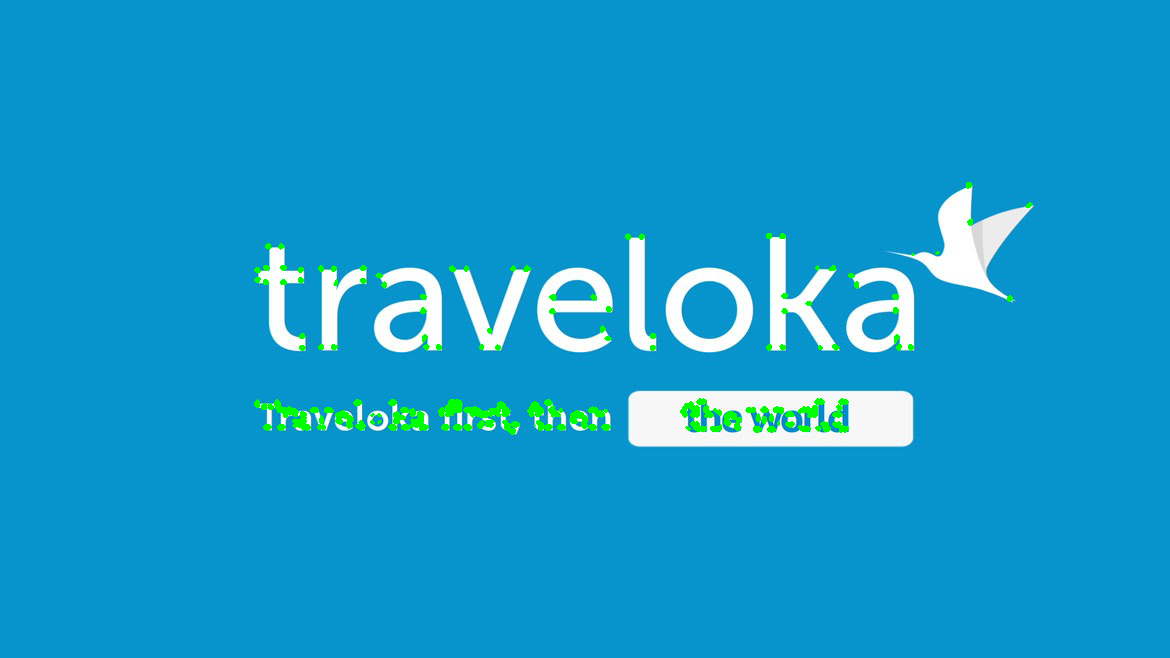

In [9]:
threshold = 0.3
thresholded_img = img.copy()
thresholded_matrix = np.zeros((height, width))
cv.normalize(R_matrix, R_matrix, 0, 1, cv.NORM_MINMAX)
for y in range(offset, height - offset):
  for x in range(offset, width - offset):
    value = R_matrix[y, x]
    if value > threshold:
      cv.circle(thresholded_img, (x, y), 1, (0, 255, 0))
      thresholded_matrix[y, x] = value

cv_imshow(thresholded_img)

Alike to edge detection, we can also perform non maximum suppression by identifying the local maxima value of the response function (R).

In [10]:
shift_x = [-1, 0, 1, -1, 1, -1, 0, 1]
shift_y = [-1, -1, -1, 0, 0, 1, 1, 1]
for y in range(1, height - 1):
  for x in range(1, width - 1):
    local_maxima = 0
    for index in range(len(shift_x)):
      sx = shift_x[index]
      sy = shift_y[index]
      
      if thresholded_matrix[y + sy, x + sx] > local_maxima:
        local_maxima = thresholded_matrix[y + sy, x + sx]
      else:
        thresholded_matrix[y + sy, x + sx] = 0

Let's check the detected corners on the image.

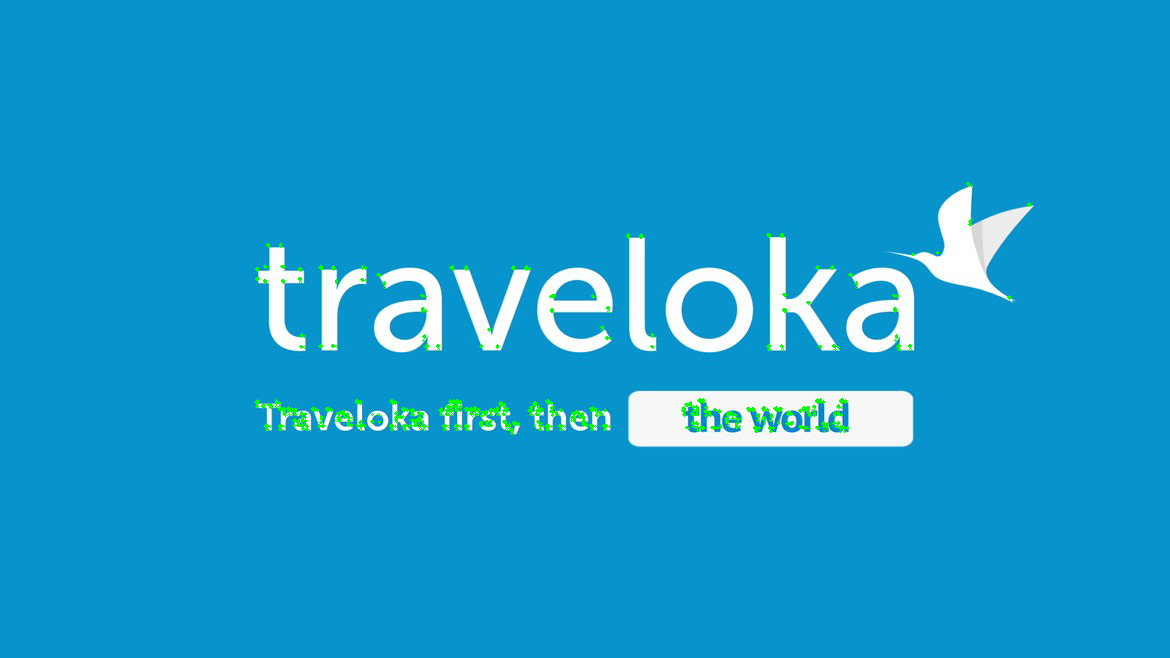

In [11]:
threshold = 0.3
suppressed_img = img.copy()
for y in range(offset, height - offset):
  for x in range(offset, width - offset):
    value = thresholded_matrix[y, x]

    if value > threshold:
      cv.circle(suppressed_img, (x, y), 1, (0, 255, 0))

cv_imshow(suppressed_img)

It is looking very convincing. Last but not least, we can create an overview of how the image has transformed during the entire demonstration.

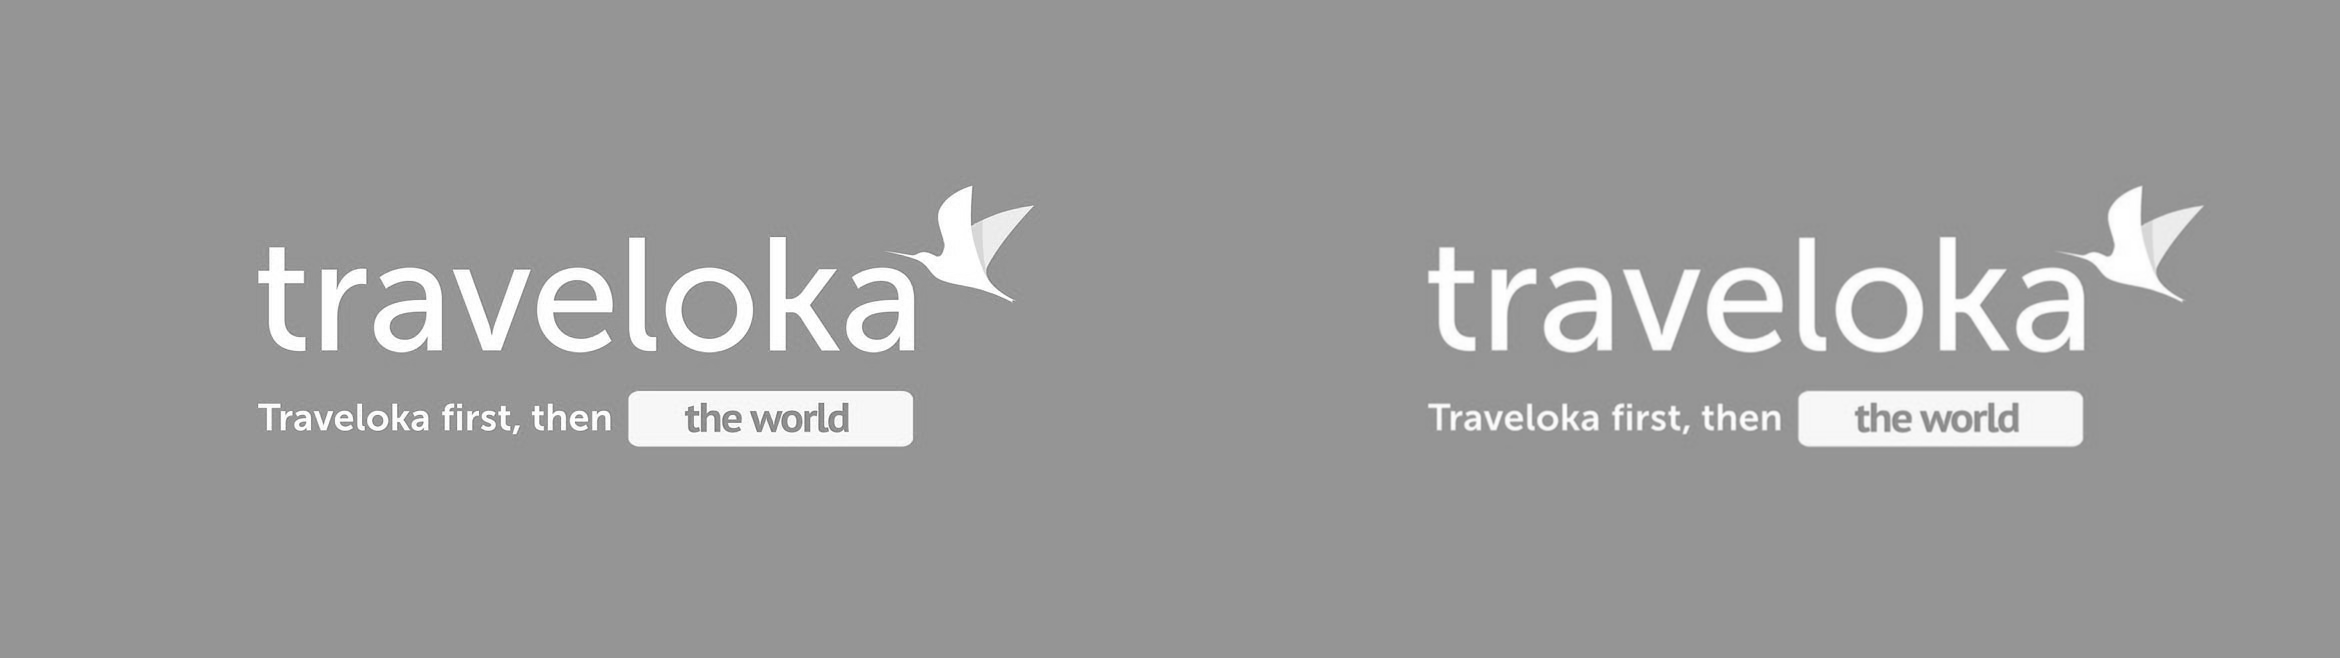

In [12]:
cv_imshow(cv.hconcat((gray_img, gaussian_img)))

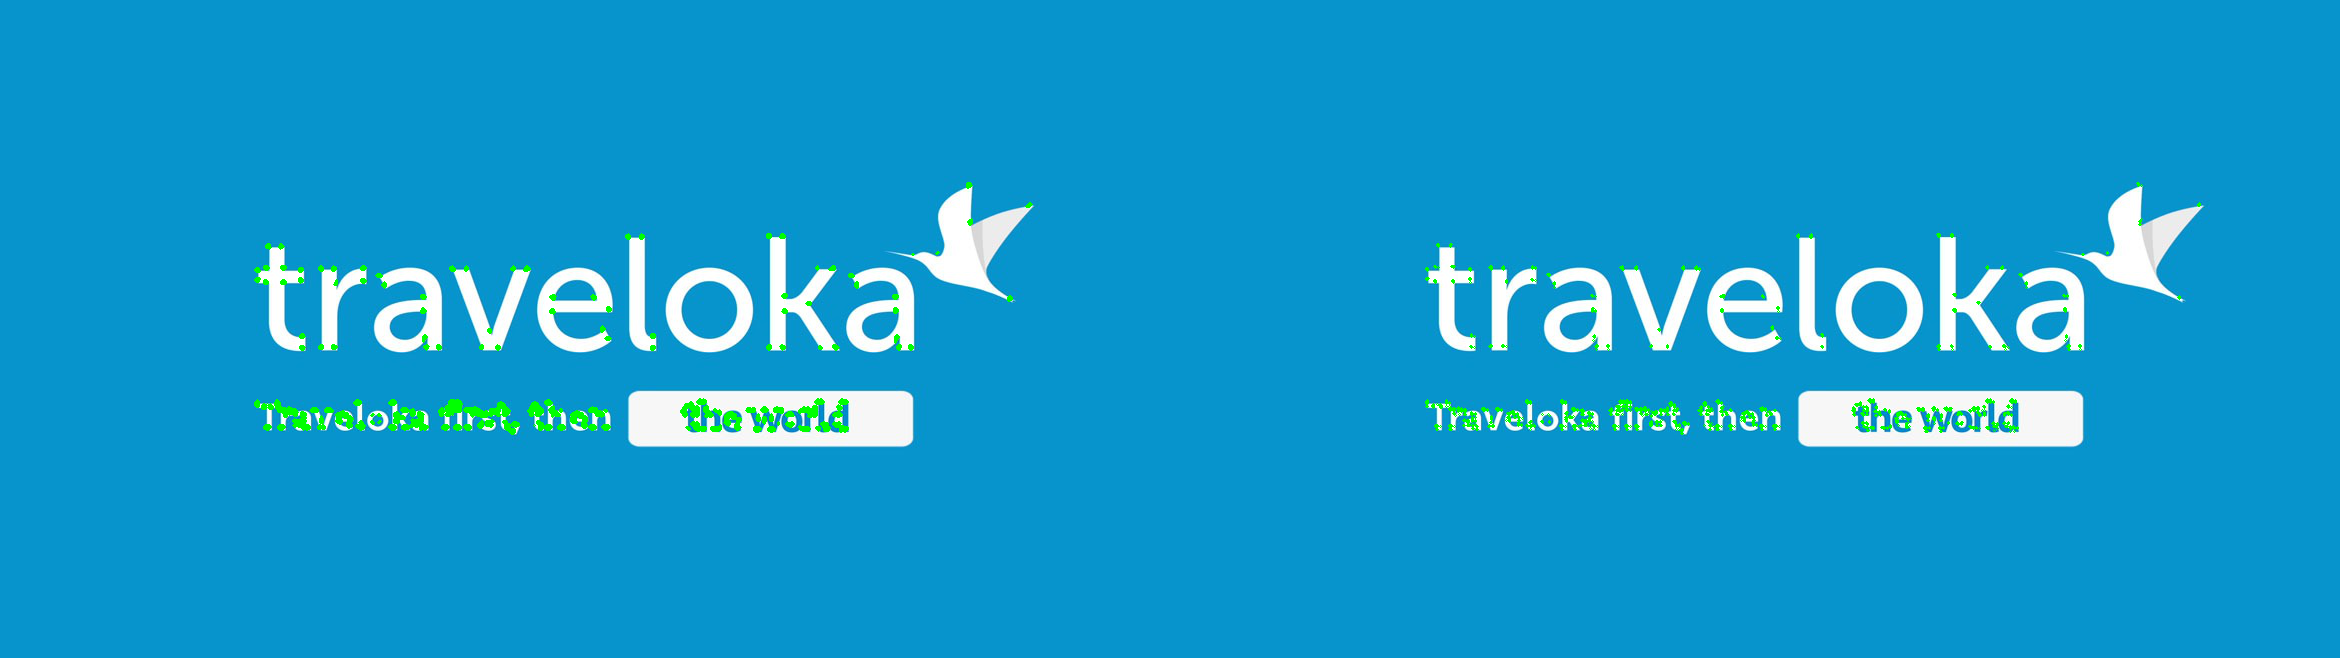

In [13]:
cv_imshow(cv.hconcat((thresholded_img, suppressed_img)))